In [25]:
# Imports and setup
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_dense_adj
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import logging
from sklearn.decomposition import PCA

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
plt.style.use('seaborn')

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj
import logging

class MolecularGVAE(nn.Module):
    def __init__(self, node_features=3, hidden_dim=64, latent_dim=32):
        super(MolecularGVAE, self).__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.enc_conv1 = GATv2Conv(node_features, hidden_dim)
        self.enc_conv2 = GATv2Conv(hidden_dim, hidden_dim)

        # Use GroupNorm instead of BatchNorm
        self.enc_norm1 = nn.GroupNorm(8, hidden_dim)
        self.enc_norm2 = nn.GroupNorm(8, hidden_dim)

        # Latent space
        self.node_mu = nn.Linear(hidden_dim, latent_dim)
        self.node_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder for node features
        self.dec_node_features = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, node_features)
        )

        # Edge prediction
        self.edge_pred = nn.Sequential(
            nn.Linear(2 * latent_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, data):
        x, edge_index = data.x, data.edge_index

        if x.device.type == 'mps':
            x = x.cpu()
            edge_index = edge_index.cpu()

        h = self.enc_conv1(x, edge_index)
        h = h.view(-1, self.hidden_dim)
        h = F.relu(self.enc_norm1(h))
        h = self.enc_conv2(h, edge_index)
        h = h.view(-1, self.hidden_dim)
        h = F.relu(self.enc_norm2(h))

        h = h.to(data.x.device)

        return self.node_mu(h), self.node_logvar(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes):
        # Reconstruct node features
        node_features = self.dec_node_features(z)

        # Create full adjacency matrix of predictions
        edge_logits = torch.zeros((num_nodes, num_nodes), device=z.device)

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                # CPU fallback for MPS
                if z.device.type == 'mps':
                    zi = z[i].cpu()
                    zj = z[j].cpu()
                else:
                    zi = z[i]
                    zj = z[j]

                edge_input = torch.cat([zi, zj], dim=0)
                edge_input = edge_input.unsqueeze(0).to(z.device)
                pred = self.edge_pred(edge_input)

                # Make the adjacency matrix symmetric
                edge_logits[i, j] = pred
                edge_logits[j, i] = pred  # Symmetric edge prediction

        return node_features, edge_logits

    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparameterize(mu, logvar)
        node_features, edge_logits = self.decode(z, data.x.size(0))
        return node_features, edge_logits, mu, logvar

    def loss_function(self, node_features, edge_logits, data, node_mu, node_logvar):
        # Node feature reconstruction loss
        recon_loss = F.mse_loss(node_features, data.x)

        # Edge prediction loss
        if edge_logits.numel() > 0:
            # Convert edge_index to dense adjacency matrix
            adj = to_dense_adj(data.edge_index, max_num_nodes=data.x.size(0))[0]

            # Binary cross entropy loss on the entire adjacency matrix
            edge_loss = F.binary_cross_entropy_with_logits(edge_logits, adj)
        else:
            edge_loss = torch.tensor(0.0).to(node_features.device)

        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + node_logvar - node_mu.pow(2) - node_logvar.exp())

        # Weight the losses
        total_loss = recon_loss + edge_loss + 0.1 * kl_loss

        return total_loss, {
            'recon': recon_loss.item(),
            'edge': edge_loss.item(),
            'kl': kl_loss.item()
        }
    
    
class TrainingManager:
    def __init__(self, model_name, checkpoint_dir='checkpoints'):
        self.model_name = model_name
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        
        self.train_metrics = defaultdict(list)
        self.val_metrics = defaultdict(list)
        self.best_val_loss = float('inf')
        self.run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

    def save_checkpoint(self, epoch, model, optimizer, train_loss, val_loss, metrics):
        checkpoint_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_epoch{epoch}.pt"
        metrics_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_metrics.json"

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metrics': dict(self.train_metrics),
            'val_metrics': dict(self.val_metrics)
        }
        torch.save(checkpoint, checkpoint_path)

        metrics_dict = {
            'train': dict(self.train_metrics),
            'val': dict(self.val_metrics)
        }
        with open(metrics_path, 'w') as f:
            json.dump(metrics_dict, f, indent=4)

        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            best_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_best.pt"
            torch.save(checkpoint, best_path)
            logger.info(f"\nNew best model saved with validation loss: {val_loss:.4f}")

    def update_metrics(self, epoch_metrics, phase='train'):
        metrics_dict = self.train_metrics if phase == 'train' else self.val_metrics
        for key, value in epoch_metrics.items():
            metrics_dict[key].append(value)

    def plot_training_progress(self):
        metrics = list(self.train_metrics.keys())
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics))
        if n_metrics == 1:
            axes = [axes]
        
        for ax, metric in zip(axes, metrics):
            train_values = self.train_metrics[metric]
            ax.plot(train_values, label=f'Train {metric}', color='blue', alpha=0.7)
            
            if metric in self.val_metrics:
                val_values = self.val_metrics[metric]
                ax.plot(val_values, label=f'Val {metric}', color='red', alpha=0.7)
            
            ax.set_title(f'{metric} over Training')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_94049/65936390.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [26]:
from collections import defaultdict
import torch
from tqdm.notebook import tqdm
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, n_epochs=100, device='cpu',
                patience=10, checkpoint_frequency=5, max_grad_norm=1.0):
    """Training loop with validation and early stopping"""
    manager = TrainingManager('molecular_gvae')

    # Early stopping setup
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batch_metrics = defaultdict(float)

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]') as train_pbar:
            for batch in train_pbar:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Forward pass using the model's forward method
                node_features, edge_logits, mu, logvar = model(batch)

                # Calculate loss
                loss, metrics = model.loss_function(
                    node_features, edge_logits,
                    batch, mu, logvar
                )

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update metrics
                train_loss += loss.item()
                for k, v in metrics.items():
                    train_batch_metrics[k] += v

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': train_loss / (train_pbar.n + 1),
                    **{k: v / (train_pbar.n + 1) for k, v in train_batch_metrics.items()}
                })

        # Calculate average training metrics
        avg_train_metrics = {k: v / len(train_loader) for k, v in train_batch_metrics.items()}
        avg_train_metrics['total_loss'] = train_loss / len(train_loader)
        manager.update_metrics(avg_train_metrics, 'train')

        # Validation phase
        model.eval()
        val_loss = 0
        val_batch_metrics = defaultdict(float)

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Val]') as val_pbar:
                for batch in val_pbar:
                    batch = batch.to(device)

                    # Forward pass using the model's forward method
                    node_features, edge_logits, mu, logvar = model(batch)

                    # Calculate loss
                    loss, metrics = model.loss_function(
                        node_features, edge_logits,
                        batch, mu, logvar
                    )

                    # Update metrics
                    val_loss += loss.item()
                    for k, v in metrics.items():
                        val_batch_metrics[k] += v

                    # Update progress bar
                    val_pbar.set_postfix({
                        'loss': val_loss / (val_pbar.n + 1),
                        **{k: v / (val_pbar.n + 1) for k, v in val_batch_metrics.items()}
                    })

        # Calculate average validation metrics
        avg_val_metrics = {k: v / len(val_loader) for k, v in val_batch_metrics.items()}
        avg_val_metrics['total_loss'] = val_loss / len(val_loader)
        manager.update_metrics(avg_val_metrics, 'val')

        # Early stopping check
        if avg_val_metrics['total_loss'] < best_val_loss:
            best_val_loss = avg_val_metrics['total_loss']
            patience_counter = 0
        else:
            patience_counter += 1

        # Save checkpoint
        if (epoch + 1) % checkpoint_frequency == 0:
            manager.save_checkpoint(
                epoch, model, optimizer,
                avg_train_metrics['total_loss'],
                avg_val_metrics['total_loss'],
                {'train': avg_train_metrics, 'val': avg_val_metrics}
            )
            manager.plot_training_progress()

        # Print epoch summary
        logger.info(f"\nEpoch {epoch+1}/{n_epochs}")
        logger.info(f"Train Loss: {avg_train_metrics['total_loss']:.4f}")
        logger.info(f"Val Loss: {avg_val_metrics['total_loss']:.4f}")

        # Early stopping
        if patience_counter >= patience:
            logger.info(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

    return manager

def plot_latent_space(model, loader, device):
    """Visualize the latent space using PCA"""
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # PCA visualization
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [27]:
# Define the file for a demo protein structure
pdb_file = '/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

# Define the directory containing the PDB files
pdb_directory = '/Users/alexchilton/Downloads/archive/just100'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

In [28]:
from ProteinAnalyzer import ProteinAnalyzer
def load_pdb_files(directory):
    ''' Load all PDB files from the specified directory '''
    pdb_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pdb')]
    return pdb_files

def create_autoencoder_input_dfs(pdb_files, aa_info_file):
    ''' Create autoencoder input DataFrames for all PDB files '''
    autoencoder_input_dfs = []
    for pdb_file in pdb_files:
        analyzer = ProteinAnalyzer(pdb_file, aa_info_file)
        autoencoder_input_df = analyzer.prepare_autoencoder_input()
        autoencoder_input_dfs.append(autoencoder_input_df)
    return autoencoder_input_dfs


# Load PDB files
pdb_files = load_pdb_files(pdb_directory)

# Create autoencoder input DataFrames
autoencoder_input_dfs = create_autoencoder_input_dfs(pdb_files, aa_info_file)

In [29]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined convert the onject types to float
autoencoder_input_dfs = Utils.convert_columns_to_float(autoencoder_input_dfs)

# Verify the conversion
print(autoencoder_input_dfs[0].dtypes)
print(autoencoder_input_dfs[0].head())

X                    float64
Y                    float64
Z                    float64
AA                    object
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
dtype: object
       X      Y      Z AA   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -3.361  0.103  5.039  I  131.17464           3.862061           3.862061   
1 -0.566 -2.557  5.206  I  131.17464           3.860735           3.862061   
2 -1.398 -3.989  1.720  E  147.13074           3.856269           3.859410   
3 -1.416 -0.429  0.246  K  146.18934           3.852071           3.853129   
4  1.985  0.279  1.908  L  131.17464           3.853064           3.855114   

   Neighbor_Count  
0             1.0  
1             2.0  
2             2.0  
3             2.0  
4             2.0  


In [30]:

from Utils import Utils
# Assuming autoencoder_input_dfs is already defined
onehot_encoder = Utils.create_onehot_encoder(autoencoder_input_dfs)

encoded_autoencoder_input_dfs = [Utils.encode_values(df, onehot_encoder) for df in autoencoder_input_dfs]
#decoded_autoencoder_input_dfs = [decode_values(df) for df in new_autoencoder_input_dfs]

# Print the first few rows of the first encoded and decoded DataFrame
print(encoded_autoencoder_input_dfs[0].head())
#print(decoded_autoencoder_input_dfs[0].head())

       X      Y      Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -3.361  0.103  5.039  131.17464           3.862061           3.862061   
1 -0.566 -2.557  5.206  131.17464           3.860735           3.862061   
2 -1.398 -3.989  1.720  147.13074           3.856269           3.859410   
3 -1.416 -0.429  0.246  146.18934           3.852071           3.853129   
4  1.985  0.279  1.908  131.17464           3.853064           3.855114   

   Neighbor_Count  AA_A  AA_C  AA_D  ...  AA_M  AA_N  AA_P  AA_Q  AA_R  AA_S  \
0             1.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   AA_T  AA_V  AA_W  AA_Y  
0   0.0   0.0   0.0   0.0  
1   0.0   0.

Processing 100 structures...


Creating graphs:   0%|          | 0/100 [00:00<?, ?it/s]

Created 100 graphs
Train loader: 3 batches
Validation loader: 1 batches

Sample graph statistics:
Number of nodes: 16
Number of edges: 48
Node feature dimension: 3


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


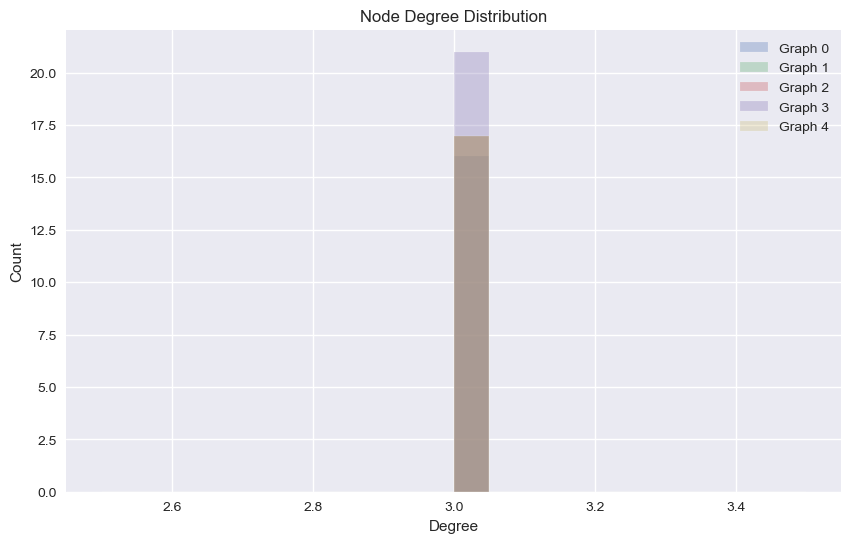

In [31]:
# Cell for data preparation
def create_graphs_from_df_array(df_array, k=3):
    """Convert array of DataFrames to list of PyG Data objects"""
    graphs = []

    for df in tqdm(df_array, desc="Creating graphs"):
        # Extract coordinates and create distance matrix
        coords = df[['X', 'Y', 'Z']].values
        distances = torch.cdist(torch.tensor(coords), torch.tensor(coords))

        # Get k nearest neighbors
        _, neighbor_indices = distances.topk(k + 1, largest=False)
        neighbor_indices = neighbor_indices[:, 1:]  # Remove self-loops

        # Create edge_index
        rows = torch.arange(len(df)).unsqueeze(1).repeat(1, k)
        edge_index = torch.stack([
            rows.flatten(),
            neighbor_indices.flatten()
        ])

        # Create node features
        feature_cols = [col for col in df.columns if col.startswith('AA_')]
        features = df[feature_cols].values
        other_features = df[['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist']].values
        node_features = np.concatenate([features, other_features], axis=1)

        # Create and append graph
        graph = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=edge_index,
            pos=torch.tensor(coords, dtype=torch.float)
        )
        graphs.append(graph)

    return graphs

# Load and process data
# Assuming df_array is your array of DataFrames
print(f"Processing {len(autoencoder_input_dfs)} structures...")

# Create graphs
graphs = create_graphs_from_df_array(autoencoder_input_dfs)
print(f"Created {len(graphs)} graphs")

# Split into train/validation sets
train_size = int(0.8 * len(graphs))
train_graphs = graphs[:train_size]
val_graphs = graphs[train_size:]

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)

print(f"Train loader: {len(train_loader)} batches")
print(f"Validation loader: {len(val_loader)} batches")

# Optional: Quick data inspection
sample_graph = graphs[0]
print("\nSample graph statistics:")
print(f"Number of nodes: {sample_graph.x.size(0)}")
print(f"Number of edges: {sample_graph.edge_index.size(1)}")
print(f"Node feature dimension: {sample_graph.x.size(1)}")

# Visualize node degree distribution of first few graphs
plt.figure(figsize=(10, 6))
for i in range(min(5, len(graphs))):
    degrees = torch.bincount(graphs[i].edge_index[0])
    plt.hist(degrees.numpy(), alpha=0.3, bins=20, label=f'Graph {i}')
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.legend()
plt.show()

In [32]:
# Example usage
def main():
    # Set device
    device = get_device()
    logger.info(f"Using device: {device}")

    # Create data loaders (assuming you have your graphs ready)
    train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=16, shuffle=False)

    # Initialize model
    model = MolecularGVAE(
        node_features=3,  # Update based on your data
        hidden_dim=64,
        latent_dim=32
    ).to(device)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model
    training_manager = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        n_epochs=100,
        device=device,
        patience=10,
        checkpoint_frequency=5,
        max_grad_norm=1.0
    )

    # Visualize results
    plot_latent_space(model, train_loader, device)

if __name__ == "__main__":
    main()

INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility
INFO:__main__:Using device: cpu
/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:__main__:
Epoch 1/100
INFO:__main__:Train Loss: 5458.6343
INFO:__main__:Val Loss: 5187.4495


Epoch 2/100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 